# Data visualisation

We start by importing the data

In [1]:
import sklearn
import datetime

import os
import copy

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels as sm
import torch.utils.data as Data

#from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation 
#from tensorflow.keras.layers import MaxPooling2D, Dropout, Conv2DTranspose
#from tensorflow.keras.layers import concatenate, Concatenate
#from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras import metrics

#sklearn → model trening
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import accuracy_score, mean_squared_error, r2_score

#sklearn → data treatment
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


#from ILSTM_Soil_model_main import lstm_interprety_soil_moisture as ILSTM
from My_tools import DataFileLoader as DFL # min egen
from My_tools import StudyEstimators as SE
# path definitions

ROOT = "../../"

DATA_PATH = ROOT + "data/"

DATA_INFO = DATA_PATH + "info/"
DATA_INFO_NIBIO_FILE = DATA_INFO  + "lmt.nibio.csv"
DATA_INFO_FROST_FILE = DATA_INFO + "Frost_stations.csv"
DATA_INFO_NIBIO2FROST_FILE = DATA_INFO + "StationIDInfo.csv"
DATA_FILE_SOIL_STATIONS = DATA_INFO + "'Stasjonsliste jordtemperatur modellering.xlsx'"

DATA_COLLECTION = DATA_PATH + "raw_data/"
DATA_COLLECTION_STAT = DATA_COLLECTION + "Veret paa Aas 2013- 2017/" # pattern -> 'Veret paa Aas 2013- 2017/Veret paa Aas {YYYY}.pdf'
DATA_COLLECTION_TIME = DATA_COLLECTION + "Time 2013- 2023/" # pattern -> Time{YYYY}.xlsx
DATA_COLLECTION_NIBIO = DATA_COLLECTION + "nibio/" # pattern -> weather_data_hour_stID{id}_y{year}.csv
DATA_COLLECTION_MET = DATA_COLLECTION + "MET/" # pattern -> StationTo_{id}_FROM_{FrostID}.csv


# ID definitions

station_names = pd.read_csv(DATA_INFO_NIBIO_FILE,
                          header=0,
                          index_col = "ID")



nibio_id = {
    "Innlandet" : ["11","18","26","27"],
    "Trøndelag" : ["15","57","34","39"],
    "Østfold" : ["37","41","52","118"],
    "Vestfold" : ["30","38","42","50"] # Fjern "50" for å se om bedre resultat
}

Loading data from folders

## Function definitions

In [2]:
def show_plot(data,plot_kwarg):
    """
        plots timeseries, assumes dataframe with a 'Time' columns
    """
    for d in range(len(data)):
        if d not in plot_kwarg:
            plt.plot(data[d].Time, data[d].iloc[:,data[d].columns != "Time"])
        else:
            plt.plot(data[d].Time, data[d].iloc[:,data[d].columns != "Time"],**plot_kwarg[d])
    
    if "xlabel" in plot_kwarg: 
        plt.xlabel = plot_kwarg["xlabel"]
    else:
        plt.xlabel = "Time"
        
    if "ylabel" in plot_kwarg: 
        plt.ylabel = plot_kwarg["ylabel"]
    else:
        plt.ylabel = "celsius degrees ℃"

def table2Latex(table, dir_path, file_name, header = "", append = False):
    if os.path.isfile(dir_path + file_name + ".tex") & append:
        file = open(dir_path+filename+".tex","a", encoding="utf-8")
    else:
        file = open(dir_path+filename+".tex","w", encoding="utf-8")

    file.write(r"\begin{tabular}{|l|" + ["c" for _ in range(len(header))].join("|") + "|}")
    if header != "":
        file.write(header.join("&") + r"\\\hline")
    for row in table:
        file.write(row.join("&") + r"\\\hline")
    file.write(r"\end{tabular}")

In [3]:
nibio_data_ungroup = DFL.DataFileLoader(DATA_COLLECTION_NIBIO,r"weather_data_hour_stID(\d{1,3})_y(\d{4}).csv")
nibio_data_ungroup.load_data(names = ["Time","TM","RR","TJM10","TJM20"])
nibio_data = nibio_data_ungroup.group_layer(nibio_id)

nibio_data_raw_ungroup = DFL.DataFileLoader(DATA_COLLECTION_NIBIO,r"weather_data_raw_hour_stID(\d{1,3})_y(\d{4}).csv")
nibio_data_raw_ungroup.load_data(names = ["Time","TM","RR","TJM10","TJM20"])
nibio_data_raw = nibio_data_raw_ungroup.group_layer(nibio_id)

started load
ended load
started load
ended load


In [4]:
def dataframe_merge_func(x,y):
    y.iloc[y.iloc[:,1].notna() & (y.iloc[:,1] <= 0),2] = pd.NA
    x.iloc[0:y.shape[0],2] = y.iloc[0:y.shape[0],2]
    return x

imputed_nibio_data = nibio_data.combine(nibio_data_raw,merge_func = dataframe_merge_func)

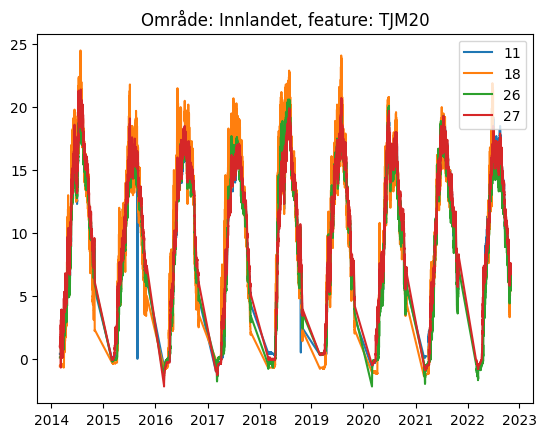

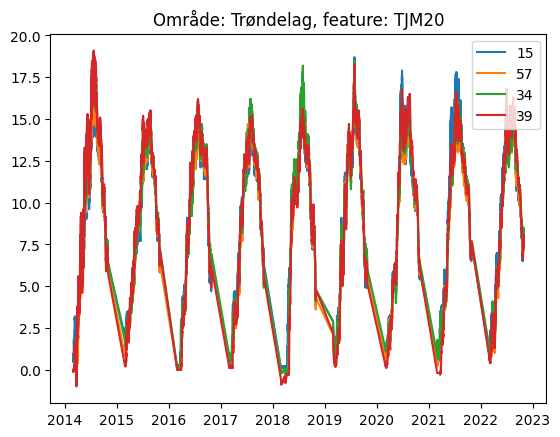

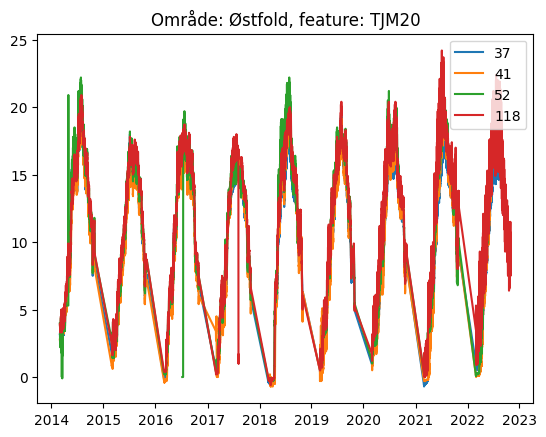

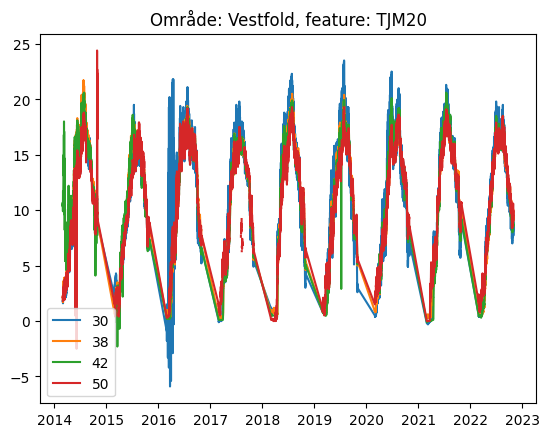

In [5]:
for regi in nibio_id.keys(): 
    show_plot([station.loc[:,["Time","TJM20"]] for station in imputed_nibio_data[regi,:].shave_top_layer().merge_layer(level=1).flatten()],{})
    plt.legend(nibio_id[regi])
    plt.title("Område: {}, feature: {}".format(regi,"TJM20"))
    plt.show()

The data is splitted among two collections of data, one is a pdf and the other is a `.xlsx` format. We start by collecting the data from the hourly data collection.

In [6]:
df = imputed_nibio_data["Vestfold","42","2019"].merge_layer()

Q1 = df["TJM20"].quantile(0.10)
Q3 = df["TJM20"].quantile(0.90)
IQR = Q3-Q1
lb = Q1 - 1.5*IQR
ub = Q3 + 1.5*IQR

print(df[(df["TJM20"] < lb) | (df["TJM20"] > ub) ])

from sklearn.neighbors import LocalOutlierFactor
model = LocalOutlierFactor(contamination=0.1)
#df["Time"] = df.transform({"Time":lambda x: x.day_of_year*24 + x.hour})
outliers = model.fit_predict(df.loc[:,["TJM10","TJM20"]].fillna(0).to_numpy())
show_plot([df.loc[(outliers > 0) and (np.array(df.index) > 4000) and (np.array(df.index) < 4900),["Time","TJM20"]],df.loc[4000:4900,["Time","TJM20"]].fillna(0)],{})

Empty DataFrame
Columns: [Time, TM, RR, TJM10, TJM20]
Index: []


C:\Users\matsh\AppData\Local\Temp\ipykernel_22656\3749762320.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  outliers = model.fit_predict(df.loc[:,["Time","TJM20"]].fillna(0).to_numpy())


TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [ ]:
df.index

## Linear regression function 

This function does a transformation of the $m\times n$ matrix (our dataframe) to a $m \times p$ matrix. This can be seen as a kernel trick where we transform the data to a more seperable state to improve prediction. The scema for this model is
$$
    (\vec{F}\circ \mathbf{A})\vec{\beta}=\vec{y}+\vec{\varepsilon}
$$

In [ ]:
def all_permute(L):
    """
        makes a list of size 2^len(L)-1 with all combinations
    """
    from itertools import permutations
    final_list = list(L)
    for n in range(2,len(L)+1): 
        final_list.extend(set(permutations(L,n)))
    return final_list

def mediant(x: float,y: float):
    """
        Takes the mediant of two fractions
            a/b + c/d = (a+c)/(b+d)
    """
    frac_x = x.as_integer_ratio()
    frac_y = y.as_integer_ratio()
    comb_xy = (frac_x[0] + frac_y[0],frac_x[1] + frac_y[1])
    return comb_xy[0]/comb_xy[1]

def combine_years(X,Y):
    """
        Combines two dataframes
    """
    if isinstance(X,list) or isinstance(Y,list):
        pass
    if X.index == Y.index:
        return [X,Y]

### Plauborg regression

Author Plauborg used the above model to predict soil temperature, but used previus time to make the model more time dependent and fourier terms to reflect changes during the year.

In [ ]:
best_plauborg = {
    "Score":np.inf,
    "mse":0,
    "r2":0,
    "year":0,
    "model":None
}

worst_plauborg = {
    "Score":-np.inf,
    "mse":0,
    "r2":0,
    "year":0,
    "model":None,
}

base_model = SE.PlauborgRegresson()

for regi in nibio_id.keys():
    for i in range(2014,2022):
        # First we fetch region (regi), all stations (:), then relevant years ("2014":str(i)). Since we only look at one region at the time
        # we remove the root group (shave_top_layer()), then we merge the years (merge_layer(level = 1), level 1 since level 0 would be the stations at this point)
        # then make a list (flatten(), the default handeling is to put leafs in a list)
        
        data = imputed_nibio_data[regi,:,"2014":str(i)].shave_top_layer().merge_layer(level = 1).flatten() # looks at all previus years including this year
        test = imputed_nibio_data[regi,:,str(i+1)].shave_top_layer().merge_layer(level = 1).flatten() # looks at the next year

        data = [d.infer_objects(copy=False).fillna(0) for d in data] # Removes nan in a quick manner
        test = [d.infer_objects(copy=False).fillna(0) for d in test] # but will be reviced.
        
        model = copy.deepcopy(base_model)
        overall_r2 = None
        for d,t in zip(data,test): # fitting model with all stations
            model.fit(d.loc[:,["Time","TM"]],d.loc[:,["TJM20"]]) # regions model
            s_model = copy.deepcopy(base_model).fit(d.loc[:,["Time","TM"]],d.loc[:,["TJM20"]]) # Station model
            if overall_r2 is not None:
                overall_r2 = 1-mediant(1-overall_r2, 1-r2_score(t["TJM20"].to_numpy(),s_model.predict(t.loc[:,["Time","TM"]])))
            else:
                overall_r2 = r2_score(t["TJM20"].to_numpy(),s_model.predict(t.loc[:,["Time","TM"]]))
            
            
        print(regi,"from year 2014 to year",i,":\n",
              "\tMSE:",
              mae := [mean_squared_error(t["TJM20"].to_numpy(),model.predict(t.loc[:,["Time","TM"]])) for t in test],
              "\n\tR2:",
              r2 := [r2_score(t["TJM20"].to_numpy(),model.predict(t.loc[:,["Time","TM"]])) for t in test])
        score = max(m/r for m,r in zip(mae,r2))
        model_info = {
                "Score":score, 
                "mse":mae, 
                "r2": r2,
                "r2_spes": overall_r2,
                "year_max": str(i+1), 
                "region": regi, 
                "model": model
            }
        if score < best_plauborg["Score"]:
            best_plauborg = model_info
        elif score > worst_plauborg["Score"]:
            worst_plauborg = model_info



In [ ]:
print(best_plauborg)
print(worst_plauborg)

best_data = imputed_nibio_data[best_plauborg["region"],:,best_plauborg["year_max"]].merge_layer(level = 0)
worst_data = imputed_nibio_data[worst_plauborg["region"],:,worst_plauborg["year_max"]].merge_layer(level = 0)

show_plot([
    pd.DataFrame({
        "Time":best_data.Time.iloc[:5879].to_numpy().ravel(),
        "TJM20":best_plauborg["model"].predict(best_data.loc[:5878,["Time","TM"]]).ravel() - best_data.loc[:5878,["TJM20"]].to_numpy().ravel()
    }) ],
    {})
plt.title("Y_pred - Y_truth")
plt.show()
show_plot([
    pd.DataFrame({
        "Time":worst_data.Time.iloc[:5879].to_numpy().ravel(),
        "TJM20":worst_plauborg["model"].predict(worst_data.loc[:5878,["Time","TM"]]).ravel() - worst_data.loc[:5878,["TJM20"]].to_numpy().ravel()
    }) ],
    {})
plt.title("Y_pred - Y_truth")
plt.show()


In [ ]:
imputed_nibio_data["Vestfold",:,"2019"].DictData

### Rankin regression

This regression tries to solve the following integreal using an FDM.

$$
T = \int_{t_0}^{t_{max}} \frac{1}{C_{A}} \frac{\partial}{\partial z}\left(K_T \frac{\partial T}{\partial z}\right) dt
$$

Where T is temperature, z is depth, and t is time. In this study we will approximate several thing including

- $K_T / C_A \approx \partial_tT/\partial^2_zT$
- $f_S \approx -0.5\ln(T^{t+1}/T_*^{t})/D_t$

best_rankin = {
    "Score":np.inf,
    "mse":0,
    "r2":0,
    "year":0,
    "model":None
}

worst_rankin = {
    "Score":-np.inf,
    "mse":0,
    "r2":0,
    "year":0,
    "model":None,
}

base_model = SE.RankinRegresson()

for regi in nibio_id.keys():
    for i in range(2014,2022):
        # First we fetch region (regi), all stations (:), then relevant years ("2014":str(i)). Since we only look at one region at the time
        # we remove the root group (shave_top_layer()), then we merge the years (merge_layer(level = 1), level 1 since level 0 would be the stations at this point)
        # then make a list (flatten(), the default handeling is to put leafs in a list)
        
        data = imputed_nibio_data[regi,:,"2014":str(i)].shave_top_layer().merge_layer(level = 1).flatten() # looks at all previus years including this year
        test = imputed_nibio_data[regi,:,str(i+1)].shave_top_layer().merge_layer(level = 1).flatten() # looks at the next year

        data = [d.infer_objects(copy=False).fillna(0) for d in data] # Removes nan in a quick manner
        test = [d.infer_objects(copy=False).fillna(0) for d in test] # but will be reviced.
        
        model = copy.deepcopy(base_model)
        overall_r2 = None
        for d,t in zip(data,test): # fitting model with all stations
            model.fit(d,d.loc[:,["TJM20"]]) # regions model
            s_model = copy.deepcopy(base_model).fit(d,d.loc[:,["TJM20"]]) # Station model
            if overall_r2 is not None:
                overall_r2 = 1-mediant(1-overall_r2, 1-r2_score(t["TJM20"].to_numpy(),s_model.predict(t)))
            else:
                overall_r2 = r2_score(t["TJM20"].to_numpy(),s_model.predict(t))
            
            
        print(regi,"from year 2014 to year",i,":\n",
              "\tMSE:",
              mae := [mean_squared_error(t["TJM20"].to_numpy(),model.predict(t)) for t in test],
              "\n\tR2:",
              r2 := [r2_score(t["TJM20"].to_numpy(),model.predict(t)) for t in test])
        score = max(m/r for m,r in zip(mae,r2))
        model_info = {
                "Score":score, 
                "mse":mae, 
                "r2": r2,
                "r2_spes": overall_r2,
                "year_max": i, 
                "region": regi, 
                "model": model
            }
        if score < best_rankin["Score"]:
            best_rankin = model_info
        elif score > worst_rankin["Score"]:
            worst_rankin = model_info

print(best_rankin)
print(worst_rankin)

## LSTM

This is a base model for testing ILSTM in the next section.

In [ ]:
best_lstm = {
    "Score":np.inf,
    "mse":0,
    "r2":0,
    "year":0,
    "model":None
}

worst_lstm = {
    "Score":-np.inf,
    "mse":0,
    "r2":0,
    "year":0,
    "model":None,
}

base_model = SE.KerasBiLSTM()

for regi in nibio_id.keys():
    for i in range(2014,2022):
        # First we fetch region (regi), all stations (:), then relevant years ("2014":str(i)). Since we only look at one region at the time
        # we remove the root group (shave_top_layer()), then we merge the years (merge_layer(level = 1), level 1 since level 0 would be the stations at this point)
        # then make a list (flatten(), the default handeling is to put leafs in a list)
        
        data = imputed_nibio_data[regi,:,"2014":str(i)].shave_top_layer().merge_layer(level = 1).flatten() # looks at all previus years including this year
        test = imputed_nibio_data[regi,:,str(i+1)].shave_top_layer().merge_layer(level = 1).flatten() # looks at the next year

        data = [d.infer_objects(copy=False).fillna(0) for d in data] # Removes nan in a quick manner
        test = [d.infer_objects(copy=False).fillna(0) for d in test] # but will be reviced. 
        for d,t in zip(data,test): # fitting model with all stations
            d["Time"] = d["Time"].transform({"Time":lambda x: x.day_of_year*24 + x.hour})
            t["Time"] = t["Time"].transform({"Time":lambda x: x.day_of_year*24 + x.hour})

        # "input_shape":[(12*n,d.shape[1]) for n in range(1,8)],

        search_area = {"input_shape":[12*n for n in range(2,14)],"lstm_units":[2**k for k in range(10,20)],"epochs":[2*n for n in range(25,50)]}

        model = GridSearchCV(copy.deepcopy(base_model),param_grid=search_area,n_jobs = -1)
        overall_r2 = None
        for d,t in zip(data,test): # fitting model with all stations
            model.fit(d.loc[:,["Time","TM","RR"]].to_numpy(),d.loc[:,["TJM20"]].to_numpy().ravel()) # regions model
            s_model = GridSearchCV(copy.deepcopy(base_model),param_grid=search_area, n_jobs = -1).fit(d.loc[:,["Time","TM","RR"]],d.loc[:,["TJM20"]]) # Station model
            if overall_r2 is not None:
                overall_r2 = 1-mediant(1-overall_r2, 1-r2_score(t["TJM20"].to_numpy().reshape(-1, 1),s_model.predict(t.loc[:,["Time","TM","RR"]].to_numpy())))
            else:
                overall_r2 = r2_score(t["TJM20"].to_numpy().reshape(-1, 1),s_model.predict(t.loc[:,["Time","TM","RR"]].to_numpy()))
            
            
        print(regi,"from year 2014 to year",i,":\n",
              "\tMSE:",
              mae := [mean_squared_error(t["TJM20"].to_numpy(),model.predict(t.loc[:,["Time","TM","RR"]].to_numpy())) for t in test],
              "\n\tR2:",
              r2 := [r2_score(t["TJM20"].to_numpy(),model.predict(t.loc[:,["Time","TM","RR"]].to_numpy())) for t in test])
        score = max(m/r for m,r in zip(mae,r2))
        model_info = {
                "Score":score, 
                "mse":mae, 
                "r2": r2,
                "r2_spes": overall_r2,
                "year_max": i, 
                "region": regi, 
                "model": model
            }
        if score < best_lstm["Score"]:
            best_lstm = model_info
        elif score > worst_lstm["Score"]:
            worst_lstm = model_info

print(best_lstm)
print(worst_lstm)

2024-03-10 14:15:27.138597: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 14:15:27.138597: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 14:15:27.138702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 14:15:27.138604: I tensorflow/core/platform/cpu_featu

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


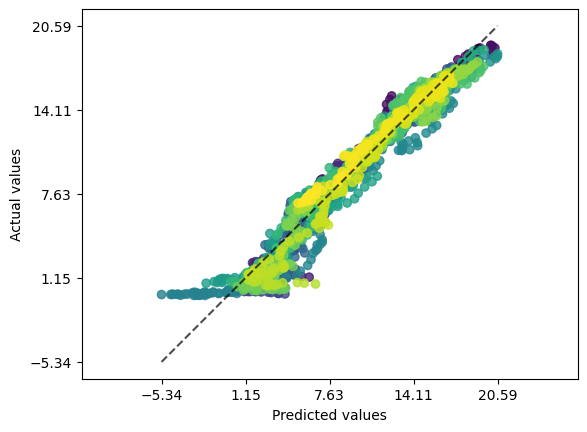

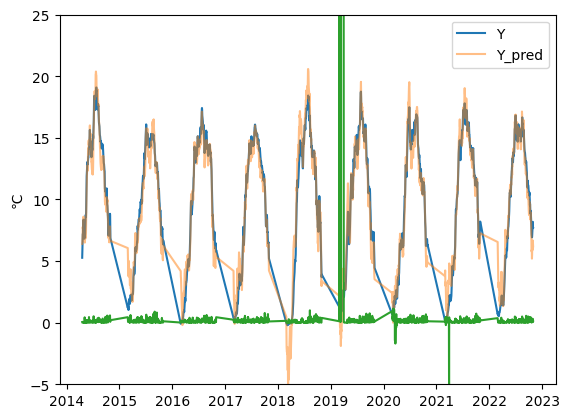

In [10]:
all_data_daily = data_t.set_index("Time").resample("D").mean().dropna().reset_index()

p_data = F_plauborg(all_data_daily)
ridge = LinearRegression().fit(p_data[50:], all_data_daily.iloc[50:,[-1]])
y_pred = ridge.predict(p_data[50:])
display = PredictionErrorDisplay(y_true=all_data_daily.iloc[50:,[-1]], y_pred=y_pred)
display.plot(kind = "actual_vs_predicted",scatter_kwargs = {
    "c": np.linspace(0,1,num = all_data_daily.iloc[50:,[-1]].shape[0]),
    "color": None
})
plt.show()

all_data_daily = all_data_daily.reset_index().loc[50:]

Y = pd.DataFrame(
    zip(all_data_daily["Time"].to_numpy().tolist(), y_pred.flatten()),
    columns=["Time","Y_pred"])

show_plot([all_data_daily.loc[:,["Time","TJM20"]],Y,all_data_daily.loc[:,["Time","RR"]]],{1:{"alpha":0.5}} )
plt.legend(["Y","Y_pred"])
plt.ylim(-5,25)
plt.ylabel("℃")
plt.show()

# ILSTM training

Here we will be training a version of LSTM

In [30]:
import copy

def ILSTM_train(raw_data, target_label,total_epoch = 50,hidden_size=16,lerningrate=1e-3, lead_time=1, seq_length=24, batch_size=16):
    data,scaler,scaler1 = ILSTM.nibio_data_transform(raw_data, target_label)
    data = scaler1.transform(data)

    # TODO: Generate the tensor for lstm model

    [data_x, data_y,data_z] = ILSTM.LSTMDataGenerator(data, lead_time, batch_size, seq_length)

       # concat all variables.
    # TODO: Flexible valid split
    data_train_x=data_x[:int((data_x.shape[0])-400*24)]
    data_train_y = data_y[:int(data_x.shape[0]-400*24)]

    train_data = Data.TensorDataset(data_train_x, data_train_y)
    train_loader = Data.DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    data_valid_x=data_x[int(data_x.shape[0]-400*24):int(data_x.shape[0]-365*24)] # -> trener 35 dager
    data_valid_y=data_y[int(data_x.shape[0]-400*24):int(data_x.shape[0]-365*24)] # -> tester 35 dager
    data_test_x=data_x[int(data_x.shape[0]-365*24):int(1.0 * data_x.shape[0])] # -> validerer på resterende
    data_testd_z=data_z[int(data_x.shape[0]-365*24):int(1.0 * data_x.shape[0])] # -> stat på rest

    # TODO: Flexible input shapes and optimizer
    # IMVTensorLSTM,IMVFullLSTM
    model = ILSTM.ILSTM_SV(data_x.shape[2],data_x.shape[1], 1, hidden_size).cuda()
    # TODO: Trian LSTM based on the training and validation sets
    model,predicor_import,temporal_import=ILSTM.train_lstm(model,lerningrate,total_epoch,train_loader,data_valid_x,data_valid_y,"./saved_models/lstm_1d.h5")

    # TODO: Create predictions based on the test sets
    pred, mulit_FV_aten, predicor_import,temporal_import = ILSTM.create_predictions(model, data_test_x,scaler)
    # TODO: Computer score of R2 and RMSE

    data_testd_z=data_testd_z.reshape(-1,1)
    data_testd_z=data_testd_z.cpu()
    data_testd_z=data_testd_z.detach().numpy()
    # Unnormalize
    data_testd_z=scaler.inverse_transform(data_testd_z)
    ILSTM.compute_rmse_r2(data_testd_z,pred,modelname)

    print(pred)
    

Need to transform the data first to fit the model.

In [26]:
def datetime2string(x):
    x["Time"] = x["Time"].apply(lambda y: y.strftime("%Y-%m-%d %X"))
    return x
station_data = imputed_nibio_data.data_transform(datetime2string).merge_layer(level = 1)

In [31]:
ILSTM_train(copy.deepcopy(station_data["11"]),"TJM20",batch_size = 8,total_epoch = 20)

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:933: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:933: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (tor

0 tain_Loss: 0.0006527170771732926 validation_Loss: 0.009288888424634933
1 tain_Loss: 0.00021295517217367887 validation_Loss: 0.005685048643499613
2 tain_Loss: 9.34299714572262e-06 validation_Loss: 0.004719177260994911
3 tain_Loss: 1.7839050997281447e-05 validation_Loss: 0.00508963642641902
4 tain_Loss: 2.1484449462150224e-05 validation_Loss: 0.005216263700276613
5 tain_Loss: 3.079278758377768e-05 validation_Loss: 0.0052984911017119884
6 tain_Loss: 3.515339267323725e-05 validation_Loss: 0.005313002038747072
7 tain_Loss: 3.841256693704054e-05 validation_Loss: 0.005322385113686323
8 tain_Loss: 4.288393029128201e-05 validation_Loss: 0.005322808399796486
9 tain_Loss: 4.586366412695497e-05 validation_Loss: 0.005387068726122379
10 tain_Loss: 4.343436739873141e-05 validation_Loss: 0.005386139266192913
11 tain_Loss: 2.8948226827196777e-05 validation_Loss: 0.005369795951992273
12 tain_Loss: 1.9895232981070876e-05 validation_Loss: 0.0053549776785075665
13 tain_Loss: 1.578812771185767e-05 validat

Traceback (most recent call last):
  File "C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\matsh\AppData\Local\Temp\ipykernel_22516\1875538552.py", line 1, in <module>
    ILSTM_train(copy.deepcopy(station_data["11"]),"TJM20")
  File "C:\Users\matsh\AppData\Local\Temp\ipykernel_22516\1250756675.py", line 33, in ILSTM_train
    model,predicor_import,temporal_import=ILSTM.train_lstm(model,lerningrate,total_epoch,train_loader,data_valid_x,data_valid_y,"./saved_models/lstm_1d.h5")
  File "D:\OneDrive - Norwegian University of Life Sciences\uni\MASTER OPPGAVE\MT24CS\programs\python\ILSTM_Soil_model_main\lstm_interprety_soil_moisture.py", line 169, in train_lstm
    output, mulit_FV_aten, predicor_aten,temporal_aten = model(x)
  File "C:\Users\matsh\AppData\Local\Packages\Pyt